# Pangeo REMA Example

Data live in Google Cloud Storage region `US-CENTRAL-1`.

Files have been encoded as COGs. The URLs have the format:

`https://storage.googleapis.com/pangeo-pgc/8m/{row}_{col}/{row}_{col}_8m_dem_COG_LZW.tif`

### Create Dask Cluster for Parallel Processing

In [1]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster(n_workers=20)
client = Client(cluster)
cluster

distributed.scheduler - INFO - Clear task state
/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:    tcp://10.32.0.37:38851
distributed.scheduler - INFO -   dashboard at:                    :35861
distributed.scheduler - INFO - Receive client connection: Client-13995018-6920-11ea-83d6-064f22203277
distributed.core - INFO - Starting established connection


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import hvplot.xarray
from matplotlib import pyplot as plt
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import skimage.morphology
#import richdem as rd
import scipy.ndimage

import cartopy.crs as ccrs


#From the DEM generator
import scipy.spatial as spl
import scipy.sparse as spa
import scipy.sparse.csgraph as csg
import scipy.sparse.linalg as sla

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


### Load a range of 8m images (lazily)

In [3]:
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(range(38, 36, -1)): #amery 
    cols = []
    for j in range(47, 53):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)

In [4]:
[len(r) for r in rows]

[6, 6]

### Concat into a single huge Xarray dataset

In [5]:
dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds.data

,Array,Chunk
Bytes,7.50 GB,67.11 MB
Shape,"(1, 25000, 75000)","(1, 4096, 4096)"
Count,972 Tasks,192 Chunks
Type,float32,numpy.ndarray


In [6]:
ds_array = ds.squeeze()
ds_array.data

dask.array<getitem, shape=(25000, 75000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [7]:
ds_array

<xarray.DataArray (y: 25000, x: 75000)>
dask.array<getitem, shape=(25000, 75000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 1.6e+06 1.6e+06 1.6e+06 ... 2.2e+06 2.2e+06 2.2e+06
    band     int64 1
  * y        (y) float64 8e+05 8e+05 8e+05 8e+05 ... 6e+05 6e+05 6e+05 6e+05
Attributes:
    crs:                 +init=epsg:3031
    res:                 (8.0, 8.0)
    is_tiled:            1
    nodatavals:          (-9999.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

In [8]:
ds_array = ds_array.fillna(-9999)

distributed.scheduler - INFO - Register tcp://10.32.2.2:34257
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.2.2:34257
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.2.3:37713
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.2.3:37713
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.22.3:36109
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.22.3:36109
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.22.2:37105
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.22.2:37105
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.24.3:34245
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.24.3:34245
distributed.core - INFO - S

## LandLab

In [31]:
from landlab import RasterModelGrid


In [32]:
(67.794247,68.314200, -73.031647,-72)

(67.794247, 68.3142, -73.031647, -72)

In [33]:
elev_array = ds_array.coarsen(x=50, y=50).mean()#ds.coarsen(x=50, y=50).mean()[:,150:250,300:600]
elev_array

<xarray.DataArray (y: 500, x: 1500)>
dask.array<mean_agg-aggregate, shape=(500, 1500), dtype=float32, chunksize=(82, 82), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 1.6e+06 1.601e+06 1.601e+06 ... 2.199e+06 2.2e+06
    band     int64 1
  * y        (y) float64 7.998e+05 7.994e+05 7.99e+05 ... 6.006e+05 6.002e+05
Attributes:
    crs:                 +init=epsg:3031
    res:                 (8.0, 8.0)
    is_tiled:            1
    nodatavals:          (-9999.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

In [34]:
#plt.pcolormesh(elev_array)

In [35]:
#rotate data
#elev_array = np.flipud(elev_array)

In [205]:
elev_array_ss = elev_array.sel(x=slice(1.6639e+06,1.9387e+06)).sel(y=slice(7.3626e+05,6.8428e+05))

In [206]:
elev_array_ss

<xarray.DataArray (y: 130, x: 687)>
dask.array<getitem, shape=(130, 687), dtype=float32, chunksize=(82, 82), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 1.664e+06 1.665e+06 1.665e+06 ... 1.938e+06 1.939e+06
    band     int64 1
  * y        (y) float64 7.362e+05 7.358e+05 7.354e+05 ... 6.85e+05 6.846e+05
Attributes:
    crs:                 +init=epsg:3031
    res:                 (8.0, 8.0)
    is_tiled:            1
    nodatavals:          (-9999.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

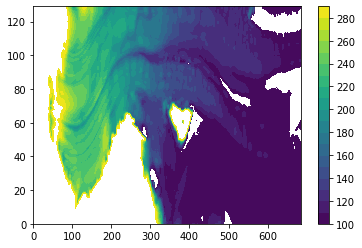

In [207]:
ax, fig = plt.subplots()
elevplot = plt.contourf(np.flipud(elev_array_ss),levels=np.arange(100,300,10))
#[y, x] = np.where(elev_array<10)
##plt.scatter(x,y)
plt.colorbar(elevplot)

In [208]:
elev_array_ss = elev_array_ss*(elev_array_ss<700)
elev_array_ss = elev_array_ss*(elev_array_ss>10) #There's one point that's 3m asl
#elev_array = np.float_(elev_array)
#elev_array[elev_array==0] = np.nan
elev_array_ss = elev_array_ss*(skimage.morphology.remove_small_objects(np.bool_(elev_array_ss), min_size=1000))


distributed.scheduler - INFO - Remove worker tcp://10.32.39.3:46149
distributed.core - INFO - Removing comms to tcp://10.32.39.3:46149


In [209]:
#plt.pcolormesh(elev_array_ss)

In [210]:
mg = RasterModelGrid((elev_array_ss.shape[0], elev_array_ss.shape[1]), 1.)
mg

RasterModelGrid((130, 687), xy_spacing=(1.0, 1.0), xy_of_lower_left=(0.0, 0.0))

In [211]:
z = mg.add_zeros('node', 'topographic__elevation')
z

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [212]:
z = mg.add_field('node', 'topographic__elevation', np.float_(elev_array_ss), units='m', copy=True, clobber=True)
mg.axis_units = ('m', 'm')
z>0

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [213]:
sw_d = mg.add_zeros('node','surface_water__depth')
sw_d = mg.add_field('node', 'surface_water__depth', .1*np.ones(z.shape)*(z>0), units='m', copy=True, clobber=True)
sw_z = mg.add_zeros('node','surface_water__elevation')
sw_z = mg.add_field('node', 'surface_water__elevation', sw_d +z, units='m', copy=True, clobber=True)

In [214]:
from landlab import imshow_grid
#imshow_grid(mg,'surface_water__elevation')
#(sw_z[sw_z>0]).min()

In [215]:
mg.set_watershed_boundary_condition_outlet_id(
                    7372,#randomly chose outlet id from list from set_watershed_boundary_condition
                    node_data = sw_z,
                    nodata_value=-9999)

In [216]:
for edge in (mg.nodes_at_left_edge, mg.nodes_at_right_edge):
    mg.status_at_node[edge] = mg.BC_NODE_IS_CLOSED
for edge in (mg.nodes_at_top_edge, mg.nodes_at_bottom_edge):
    mg.status_at_node[edge] = mg.BC_NODE_IS_CLOSED
    


In [217]:
mg.set_status_at_node_on_edges(right=mg.BC_NODE_IS_CLOSED,
                               top=mg.BC_NODE_IS_CLOSED,
                               left=mg.BC_NODE_IS_FIXED_VALUE,
                               bottom=mg.BC_NODE_IS_FIXED_VALUE)


In [218]:
from landlab import imshow_grid
#imshow_grid(mg, mg.status_at_node, color_for_closed="blue")

In [219]:
#mg.status_at_node[2760:2790] = mg.BC_NODE_IS_FIXED_VALUE
mg.status_at_node[mg.nodes_at_right_edge] = mg.BC_NODE_IS_FIXED_VALUE


mg.status_at_node[trouble_points]

In [220]:
#mg.set_fixed_value_boundaries_at_grid_edges()

min_swz = np.min(sw_z[np.where(z > 0)])
max_swz = np.max(sw_z[np.where(z > 0)])
plt.figure(figsize=((10,10)))
imshow_grid(mg, 'surface_water__elevation', limits=(min_swz, max_swz))
plt.scatter(mg.node_x[mg.nodes_at_right_edge],mg.node_y[mg.nodes_at_right_edge])

In [221]:
# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator
from landlab.components import (FlowDirectorD8, FlowDirectorDINF,
                                FlowDirectorMFD, FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter

# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot

import scipy.signal

In [222]:
fa = FlowAccumulator(mg,
                     surface='topographic__elevation',
                     flow_director='FlowDirectorD8',
                     depression_finder='DepressionFinderAndRouter')

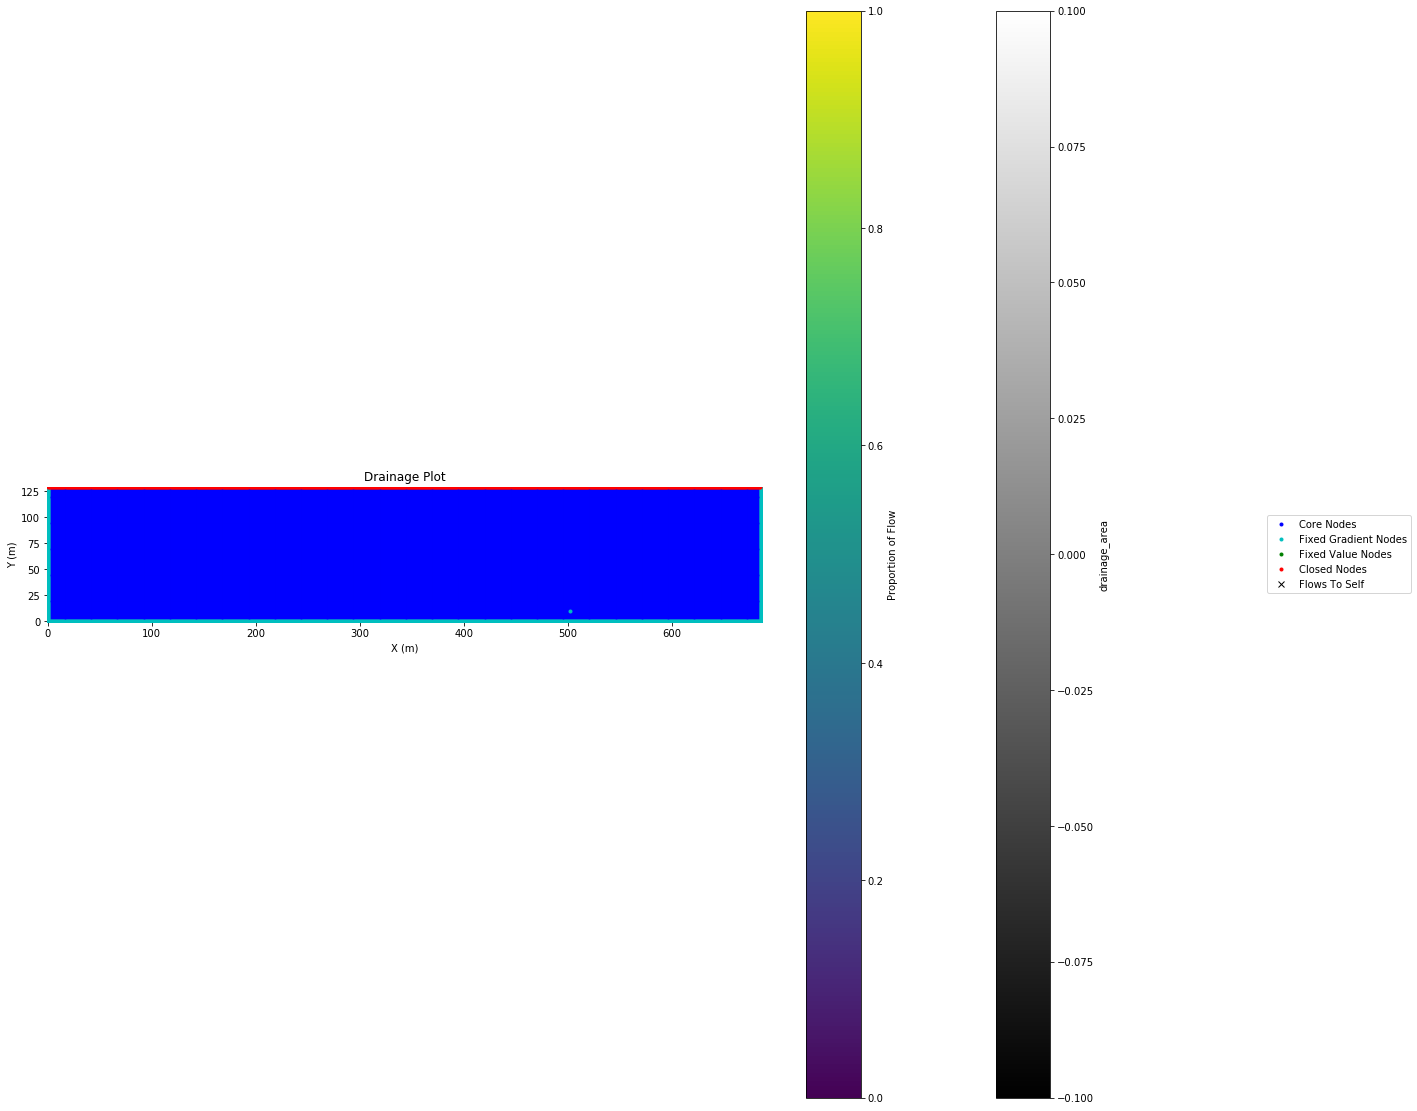

In [223]:
plt.figure(figsize=(20,20))
drainage_plot(mg, 'drainage_area')

In [224]:
#Need to identify depressions


In [225]:
dem_nans = (elev_array_ss==-9999)

In [226]:
dem_nans = scipy.ndimage.morphology.binary_dilation(dem_nans)

distributed.utils_perf - INFO - full garbage collection released 94.24 MB from 97135 reference cycles (threshold: 10.00 MB)


In [227]:
dem_nans = dem_nans.ravel()

def accumulate_flow(df, update_flow_director=True):
        """Function to make FlowAccumulator calculate drainage area and
        discharge.
        Running run_one_step() results in the following to occur:
            1. Flow directions are updated (unless update_flow_director is set
            as False).
            2. Intermediate steps that analyse the drainage network topology
            and create datastructures for efficient drainage area and discharge
            calculations.
            3. Calculation of drainage area and discharge.
            4. Depression finding and mapping, which updates drainage area and
            discharge.
        """
        # set a couple of aliases
        a = self._grid["node"]["drainage_area"]
        q = self._grid["node"]["surface_water__discharge"]

        # step 1. Find flow directions by specified method
        if update_flow_director:
            self._flow_director.run_one_step()

        # further steps vary depending on how many recievers are present
        # one set of steps is for route to one (D8, Steepest/D4)

        # step 2. Get r
        r = as_id_array(self._grid["node"]["flow__receiver_node"])

        if self._flow_director._to_n_receivers == "one":

            # step 2b. Run depression finder if passed
            # Depression finder reaccumulates flow at the end of its routine.
            # At the moment, no depression finders work with to-many, so it
            # lives here
            if self._depression_finder_provided is not None:
                self._depression_finder.map_depressions()

                # if FlowDirectorSteepest is used, update the link directions
                if self._flow_director._name == "FlowDirectorSteepest":
                    self._flow_director._determine_link_directions()

            # step 3. Stack, D, delta construction
            nd = as_id_array(flow_accum_bw._make_number_of_donors_array(r))
            delta = as_id_array(flow_accum_bw._make_delta_array(nd))
            D = as_id_array(flow_accum_bw._make_array_of_donors(r, delta))
            s = as_id_array(flow_accum_bw.make_ordered_node_array(r))

            # put these in grid so that depression finder can use it.
            # store the generated data in the grid
            self._grid.at_node["flow__data_structure_delta"][:] = delta[1:]
            self._D_structure = D
            self._grid.at_node["flow__upstream_node_order"][:] = s

            # step 4. Accumulate (to one or to N depending on direction method)
            a[:], q[:] = self._accumulate_A_Q_to_one(s, r)

        else:
            # Get p
            p = self._grid["node"]["flow__receiver_proportions"]

            # step 3. Stack, D, delta construction
            nd = as_id_array(flow_accum_to_n._make_number_of_donors_array_to_n(r, p))
            delta = as_id_array(flow_accum_to_n._make_delta_array_to_n(nd))
            D = as_id_array(flow_accum_to_n._make_array_of_donors_to_n(r, p, delta))
            s = as_id_array(flow_accum_to_n.make_ordered_node_array_to_n(r, p))

            # put theese in grid so that depression finder can use it.
            # store the generated data in the grid
            self._grid["node"]["flow__data_structure_delta"][:] = delta[1:]
            self._D_structure = D

            self._grid["node"]["flow__upstream_node_order"][:] = s
            self._grid["node"]["flow__upstream_node_order"][:] = s

            # step 4. Accumulate (to one or to N depending on direction method)
            a[:], q[:] = self._accumulate_A_Q_to_n(s, r, p)

        return (a, q)

In [228]:
#Step by step depression finder
df = DepressionFinderAndRouter(mg)

In [229]:
df._is_pit.fill(True)

In [230]:
df._is_pit[df._grid.boundary_nodes] = False
#df._is_pit[]

In [231]:
# Loop over all active links: if one of a link's two nodes is higher
# than the other, the higher one is not a pit. Also, if they have
# equal elevations and one is an open boundary, the other is not a pit.
act_links = df._grid.active_links
h_orth = df._grid.node_at_link_head[act_links]
t_orth = df._grid.node_at_link_tail[act_links]

In [232]:
# These two lines assign the False flag to any node that is higher
# than its partner on the other end of its link
df._is_pit[
    h_orth[np.where(df._elev[h_orth] > df._elev[t_orth])[0]]
] = False
df._is_pit[
    t_orth[np.where(df._elev[t_orth] > df._elev[h_orth])[0]]
] = False
df._is_pit[
    np.nonzero(dem_nans)
] = False

In [233]:
# If we have a raster grid, handle the diagonal active links too
# (At the moment, their data structure is a bit different)
# TODO: update the diagonal link data structures
# DEJH doesn't understand why this can't be vectorized as above...
if df._D8:
    for h, t in df._grid.nodes_at_diagonal[df._grid.active_diagonals]:
        if df._elev[h] > df._elev[t]:
            df._is_pit[h] = False
        elif df._elev[t] > df._elev[h]:
            df._is_pit[t] = False
        elif df._elev[h] == df._elev[t]:
            if (
                df._grid.status_at_node[h]
                == df._grid.BC_NODE_IS_FIXED_VALUE
            ):
                df._is_pit[t] = False
            elif (
                df._grid.status_at_node[t]
                == df._grid.BC_NODE_IS_FIXED_VALUE
            ):
                df._is_pit[h] = False

# Record the number of pits and the IDs of pit nodes.
df._number_of_pits = np.count_nonzero(df._is_pit)
df._pit_node_ids = (np.where(df._is_pit)[0])

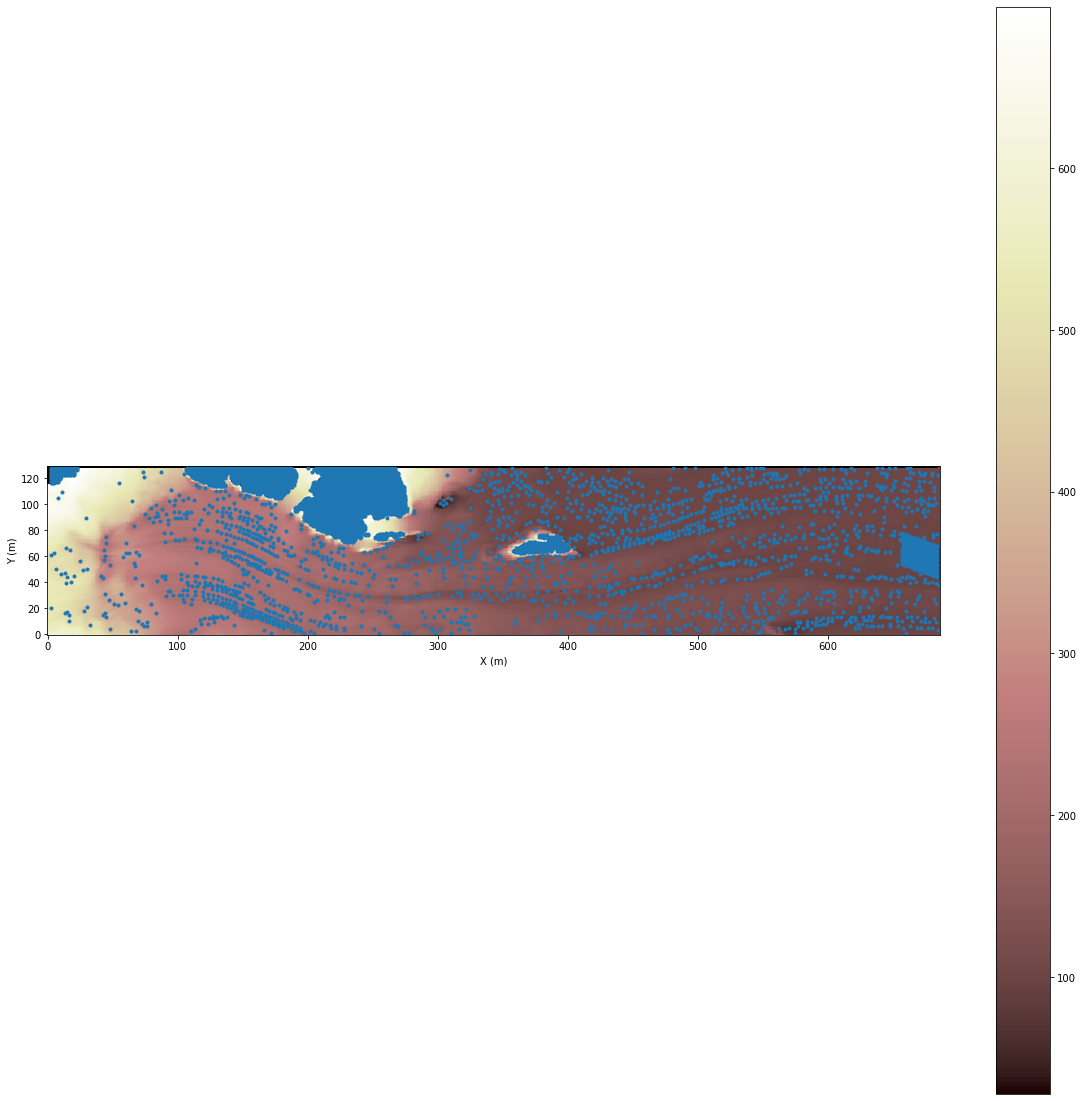

In [234]:
min_swz = np.min(sw_z[np.where(z > 0)])
max_swz = np.max(sw_z[np.where(z > 0)])
plt.figure(figsize=((20,20)))
imshow_grid(mg, 'surface_water__elevation', limits=(min_swz, max_swz))
plt.scatter(mg.node_x[df.pit_node_ids],mg.node_y[df.pit_node_ids],marker='.')

#trouble_points = [330149,328649,328648,328650,330150,330148,330151,331650,331649,331651,331652,333151,333150,330152,328647,331653,0]
#plt.scatter(mg.node_x[0:pit_node],mg.node_y[0:pit_node],marker='_')


In [235]:
from landlab import Component, FieldError, RasterModelGrid
from landlab.components.flow_accum import flow_accum_bw
from landlab.core.utils import as_id_array
#import pyximport
#pyximport.install()
import cfuncs

from cfuncs import find_lowest_node_on_lake_perimeter_c

_UNFLOODED = 0
_PIT = 1
_CURRENT_LAKE = 2
_FLOODED = 3



In [236]:
df._pit_node_ids[0]

859

In [237]:
df._pits_flooded = 0
df._depression_outlets = []
df._unique_pits = np.zeros_like(df._pit_node_ids, dtype=bool)
# debug_count = 0
for pit_node in df._pit_node_ids:
    if df._flood_status[pit_node] != _PIT:
        df._depression_outlets.append(df._grid.BAD_INDEX)
    else:
        # Flag the pit as being _CURRENT_LAKE (it's the first node in the
        # current lake)
        df._flood_status[pit_node] = _CURRENT_LAKE

        # This flag keeps track of when we're done with this depression
        found_outlet = False

        # Safety check
        count = 0
        max_count = df._grid.number_of_nodes + 1

        # Place pit_node at top of depression list
        nodes_this_depression = df.grid.zeros('node', dtype=int)
        nodes_this_depression[0] = pit_node
        pit_count = 1

        while not found_outlet:
            lowest_node_on_perimeter, pit_count = (
                find_lowest_node_on_lake_perimeter_c(df._node_nbrs,
                                                     df.flood_status,
                                                     df._elev,
                                                     nodes_this_depression,
                                                     pit_count,
                                                     df._BIG_ELEV)
            )
            # note this can return the supplied node, if - somehow - the
            # surrounding nodes are all df._grid.BAD_INDEX
            # I BELIEVE THE IS_VALID_OUTLET FN SHOULD ASSIGN FLOW DIR
            found_outlet = df.is_valid_outlet(lowest_node_on_perimeter)

            # If we haven't found an outlet, add lowest_node to the lake list
            # and flag it as being part of the current lake/depression
            if not found_outlet:
                nodes_this_depression[pit_count] = lowest_node_on_perimeter
                df._flood_status[lowest_node_on_perimeter] = _CURRENT_LAKE
                pit_count += 1

            # If we HAVE found an outlet, and we are re-routing flow, then
            # assign the proper flow direction to the outlet node. If it is an
            # open boundary, then it drains to itdf. Otherwise, call
            # assign_outlet_receiver to find the correct receiver (so that it
            # doesn't simply drain back into the lake)
            elif ("flow__receiver_node" in df._grid.at_node) and reroute_flow:
                if (
                    df._grid.status_at_node[lowest_node_on_perimeter]
                    != df._grid.BC_NODE_IS_CORE
                ):
                    df._grid.at_node["flow__receiver_node"][
                        lowest_node_on_perimeter
                    ] = lowest_node_on_perimeter
                else:
                    df.assign_outlet_receiver(lowest_node_on_perimeter)

            # Safety check, in case a bug (ha!) puts us in an infinite loop
            assert count < max_count, "too many iterations in lake filler!"
            count += 1

        df._depression_outlets.append(lowest_node_on_perimeter)
        # Now that we've mapped this depression, record it in the arrays
        # depression_depth, depression_outlet, and flood_status
        df._record_depression_depth_and_outlet(
            nodes_this_depression[:pit_count],
            lowest_node_on_perimeter, pit_node)
        df._pits_flooded += 1

In [238]:
assert len(df._depression_outlets) == df._unique_pits.size

df._unique_lake_outlets = np.array(df._depression_outlets)[
    df._unique_pits
]

In [239]:
if df._bc_set_code != df._grid.bc_set_code:
            df.updated_boundary_conditions()
            df._bc_set_code = df._grid.bc_set_code

In [240]:
df._lake_map.fill(df._grid.BAD_INDEX)
df._depression_outlet_map.fill(df._grid.BAD_INDEX)
df._depression_depth.fill(0.0)
df._depression_outlets = []  # reset these

In [241]:
# Locate nodes with pits
# Set up "lake code" array
df._flood_status.fill(_UNFLOODED)
df._flood_status[df._pit_node_ids] = _PIT

In [242]:
#Timer function
from __future__ import print_function
import sys
import threading
from time import sleep
try:
    import thread
except ImportError:
    import _thread as thread

In [243]:
try:
    range, _print = xrange, print
    def print(*args, **kwargs): 
        flush = kwargs.pop('flush', False)
        _print(*args, **kwargs)
        if flush:
            kwargs.get('file', sys.stdout).flush()            
except NameError:
    pass

In [244]:
def quit_function(fn_name):
    # print to stderr, unbuffered in Python 2.
    print('{0} took too long'.format(fn_name), file=sys.stderr)
    sys.stderr.flush() # Python 3 stderr is likely buffered.
    thread.interrupt_main() # raises KeyboardInterrupt

In [245]:
def exit_after(s):
    '''
    use as decorator to exit process if 
    function takes longer than s seconds
    '''
    def outer(fn):
        def inner(*args, **kwargs):
            timer = threading.Timer(s, quit_function, args=[fn.__name__])
            timer.start()
            try:
                result = fn(*args, **kwargs)
            finally:
                timer.cancel()
            return result
        return inner
    return outer

In [246]:
@exit_after(8*60) 
def find_depression_from_pit(df, pit_node, reroute_flow=True):
        """Find the extent of the nodes that form a pit.
        Identify extent of depression/lake whose lowest point is the node
        pit_node (which is a itself a pit, a.k.a., closed depression).
        Parameters
        ----------
        pit_node : int
            The node that is the lowest point of a pit.
        """
        # Flag the pit as being _CURRENT_LAKE (it's the first node in the
        # current lake)
        df._flood_status[pit_node] = _CURRENT_LAKE

        # This flag keeps track of when we're done with this depression
        found_outlet = False

        # Safety check
        count = 0
        max_count = df._grid.number_of_nodes + 1

        # Place pit_node at top of depression list
        nodes_this_depression = df.grid.zeros('node', dtype=int)
        nodes_this_depression[0] = pit_node
        pit_count = 1

        while not found_outlet:
            lowest_node_on_perimeter, pit_count = (
                find_lowest_node_on_lake_perimeter_c(df._node_nbrs,
                                                     df.flood_status,
                                                     df._elev,
                                                     nodes_this_depression,
                                                     pit_count,
                                                     df._BIG_ELEV)
            )
            # note this can return the supplied node, if - somehow - the
            # surrounding nodes are all df._grid.BAD_INDEX
            # I BELIEVE THE IS_VALID_OUTLET FN SHOULD ASSIGN FLOW DIR
            found_outlet = df.is_valid_outlet(lowest_node_on_perimeter)

            # If we haven't found an outlet, add lowest_node to the lake list
            # and flag it as being part of the current lake/depression
            if not found_outlet:
                nodes_this_depression[pit_count] = lowest_node_on_perimeter
                df._flood_status[lowest_node_on_perimeter] = _CURRENT_LAKE
                pit_count += 1

            # If we HAVE found an outlet, and we are re-routing flow, then
            # assign the proper flow direction to the outlet node. If it is an
            # open boundary, then it drains to itdf. Otherwise, call
            # assign_outlet_receiver to find the correct receiver (so that it
            # doesn't simply drain back into the lake)
            elif ("flow__receiver_node" in df._grid.at_node) and reroute_flow:
                if (
                    df._grid.status_at_node[lowest_node_on_perimeter]
                    != df._grid.BC_NODE_IS_CORE
                ):
                    df._grid.at_node["flow__receiver_node"][
                        lowest_node_on_perimeter
                    ] = lowest_node_on_perimeter
                else:
                    df.assign_outlet_receiver(lowest_node_on_perimeter)

            # Safety check, in case a bug (ha!) puts us in an infinite loop
            assert count < max_count, "too many iterations in lake filler!"
            count += 1

        df._depression_outlets.append(lowest_node_on_perimeter)
        # Now that we've mapped this depression, record it in the arrays
        # depression_depth, depression_outlet, and flood_status
        df._record_depression_depth_and_outlet(
            nodes_this_depression[:pit_count],
            lowest_node_on_perimeter, pit_node
        )

        # TODO: ideally we need a way to keep track of the number, area extent,
        # and average depth of depressions. Tricky thing is that one might be
        # devoured by another, so would need to be removed from the list.

In [247]:
##This cell takes the longest time
df._pits_flooded = 0
reroute_flow = True
df._unique_pits = np.zeros_like(df._pit_node_ids, dtype=bool)
# debug_count = 0

for pit_node in df._pit_node_ids:
    if df._flood_status[pit_node] != _PIT:
        df._depression_outlets.append(df._grid.BAD_INDEX)
    else:
        find_depression_from_pit(df,pit_node, reroute_flow) #<----Try to convert this to DASK
        df._pits_flooded += 1

assert len(df._depression_outlets) == df._unique_pits.size

df._unique_lake_outlets = np.array(df._depression_outlets)[
    df._unique_pits
]

In [248]:
pit_node

88599

In [249]:
pit_node/mg.number_of_core_nodes

1.0104928204016925

In [250]:
#df._identify_depressions_and_outlets(df._reroute_flow);

In [251]:
if df._reroute_flow and ("flow__receiver_node" in df._grid.at_node):
    df._receivers = df._grid.at_node["flow__receiver_node"]
    df._sinks = df._grid.at_node["flow__sink_flag"]
    df._grads = df._grid.at_node["topographic__steepest_slope"]
    df._links = df._grid.at_node["flow__link_to_receiver_node"]
    df._route_flow()
    df._reaccumulate_flow()

In [252]:
fa.accumulate_flow()

(array([  0.,   0.,   0., ...,   0.,   0.,  50.]),
 array([  0.,   0.,   0., ...,   0.,   0.,  50.]))

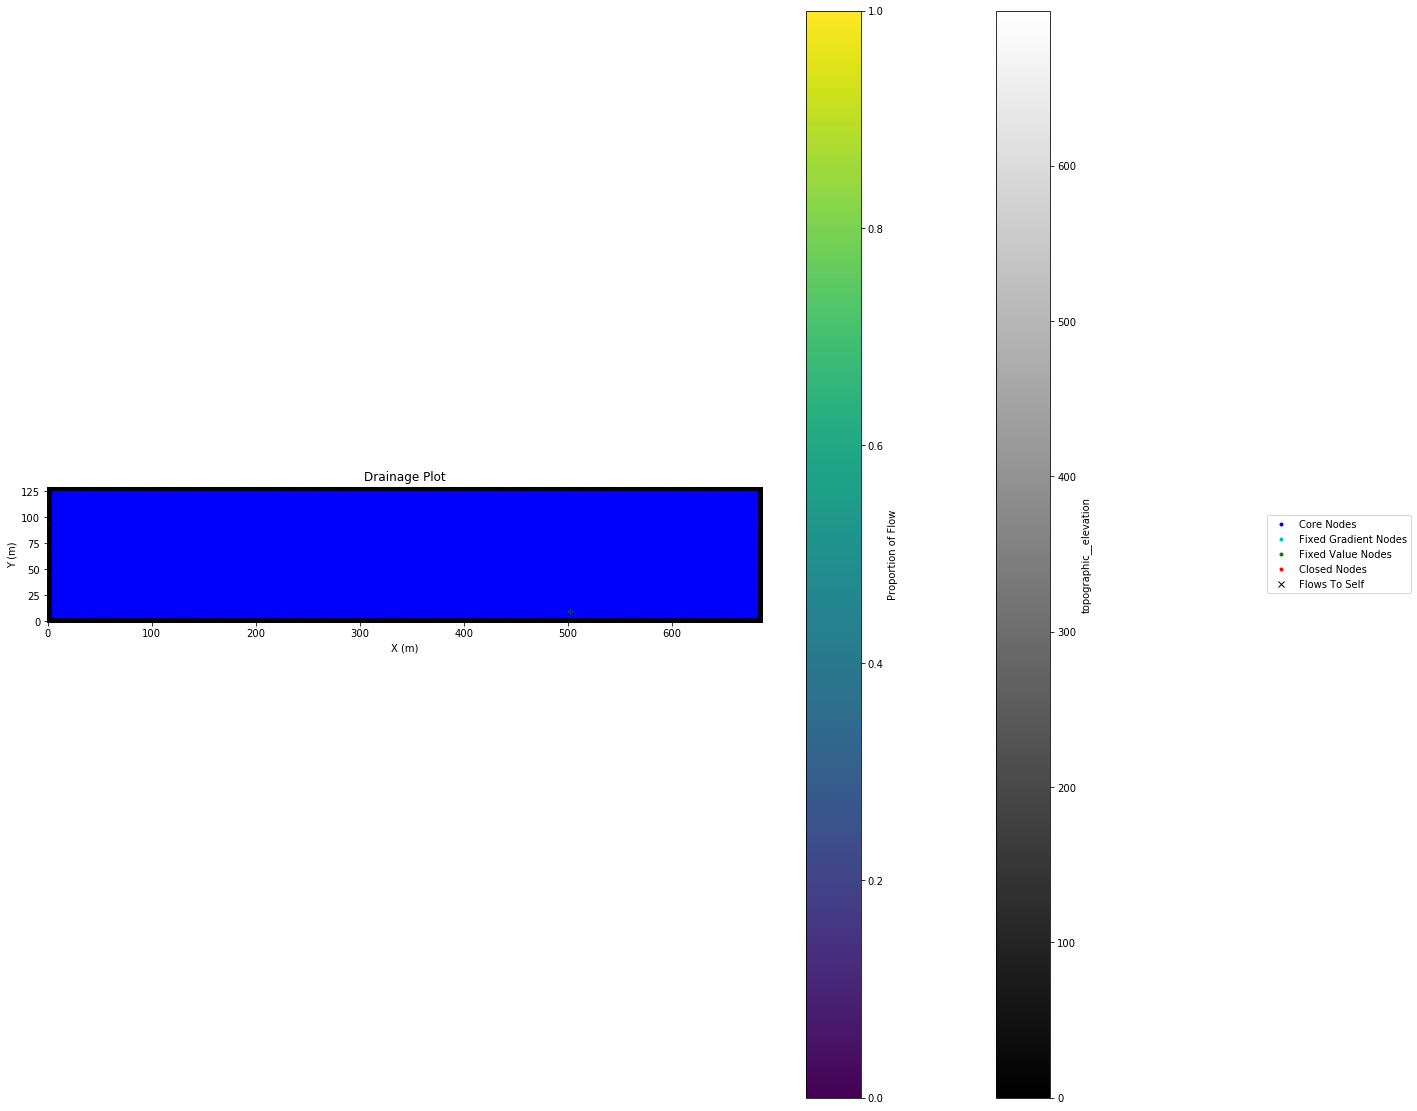

In [253]:
figure = plt.figure(figsize=(20,20))
drainage_plot(mg,)

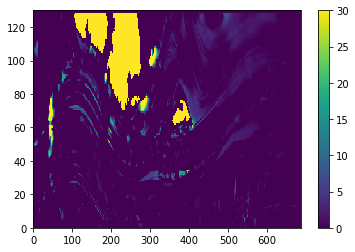

In [254]:
plt.pcolormesh(df.depression_depth.reshape(elev_array_ss.shape),vmin=0,vmax=30)
plt.colorbar()

In [255]:
from landlab.components.overland_flow import OverlandFlow
from landlab.plot.imshow import imshow_grid
from landlab.plot.colors import water_colormap

run_time = 100  # duration of run, (s)
h_init = 0.1  # initial thin layer of water (m)
n = 0.01  # roughness coefficient, (s/m^(1/3))
g = 9.8  # gravity (m/s^2)
alpha = 0.7  # time-step factor (nondimensional; from Bates et al., 2010)
u = 0.4  # constant velocity (m/s, de Almeida et al., 2012)
run_time_slices = (10, 50, 100)
elapsed_time = 1.0

of = OverlandFlow(
    mg, steep_slopes=True
)  #for stability in steeper environments, we set the steep_slopes flag to True

In [256]:
while elapsed_time < run_time:
    # First, we calculate our time step.
    dt = of.calc_time_step()
    # Now, we can generate overland flow.
    of.overland_flow()
    # Increased elapsed time
    print('Elapsed time: ', elapsed_time)
    elapsed_time += dt

Elapsed time:  1.0
Elapsed time:  1.70683165129
Elapsed time:  2.22083631527
Elapsed time:  2.63040702469
Elapsed time:  2.9708313434
Elapsed time:  3.26171483008
Elapsed time:  3.52014561257
Elapsed time:  3.74994955775
Elapsed time:  3.95680827816
Elapsed time:  4.14702161559
Elapsed time:  4.32524051526
Elapsed time:  4.4916064518
Elapsed time:  4.64793034477
Elapsed time:  4.79564689931
Elapsed time:  4.93581819755
Elapsed time:  5.07001673673
Elapsed time:  5.19863545822
Elapsed time:  5.32120789332
Elapsed time:  5.438345633
Elapsed time:  5.55057447192
Elapsed time:  5.65835154207
Elapsed time:  5.76130144245
Elapsed time:  5.86023654889
Elapsed time:  5.95624838455
Elapsed time:  6.05035369363
Elapsed time:  6.14332210589
Elapsed time:  6.23555111881
Elapsed time:  6.32681820975
Elapsed time:  6.41643902805
Elapsed time:  6.50501372086
Elapsed time:  6.59255093344
Elapsed time:  6.67850170175
Elapsed time:  6.7630714044
Elapsed time:  6.84660261861
Elapsed time:  6.92939697786


distributed.scheduler - INFO - Register tcp://10.32.38.4:36235
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.38.4:36235
distributed.core - INFO - Starting established connection


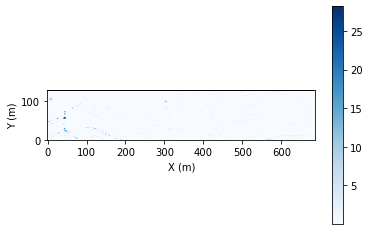

In [257]:
imshow_grid(mg, 'surface_water__depth', cmap='Blues')

In [258]:
[x,y] = np.meshgrid(elev_array_ss.x.data,elev_array_ss.y.data)
sw_depth = xr.zeros_like(elev_array_ss)
sw_depth.data = sw_d.reshape(elev_array_ss.shape)


In [259]:
import shapefile
import pycrs

AIS_Shape = shapefile.Reader('AIS_Shape_WGS1984_PS.shp')
listx=[]
listy=[]
for sr in AIS_Shape.shapeRecords():
    for xNew,yNew in sr.shape.points:
        listx.append(xNew)
        listy.append(yNew)

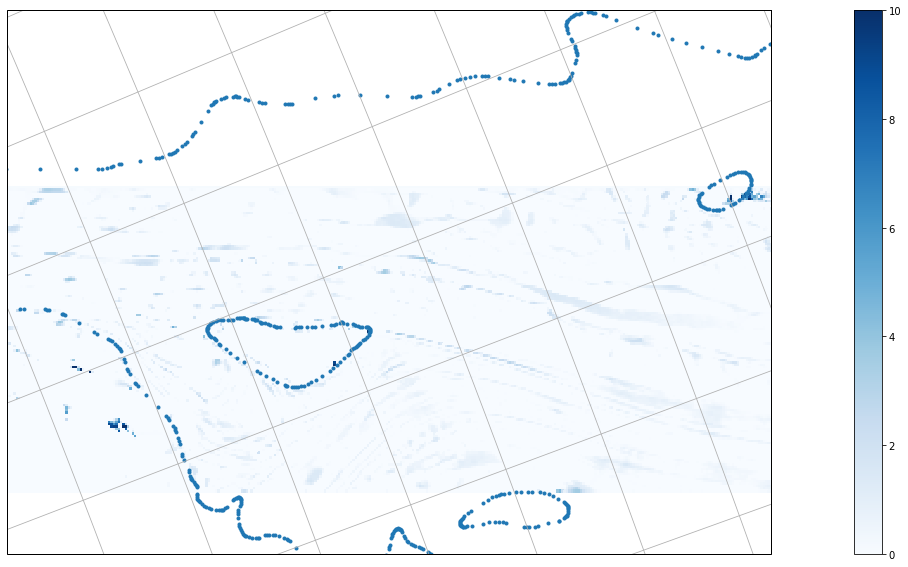

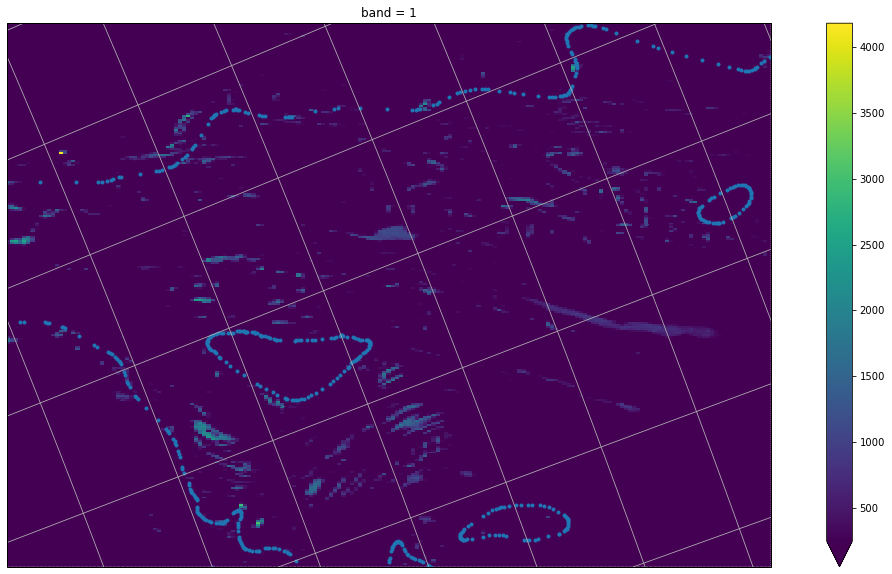

distributed.scheduler - INFO - Register tcp://10.32.42.3:33799
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.42.3:33799
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Remove worker tcp://10.32.14.2:33755
distributed.core - INFO - Removing comms to tcp://10.32.14.2:33755
distributed.scheduler - INFO - Remove worker tcp://10.32.14.4:39583
distributed.core - INFO - Removing comms to tcp://10.32.14.4:39583
distributed.scheduler - INFO - Remove worker tcp://10.32.42.3:33799
distributed.core - INFO - Removing comms to tcp://10.32.42.3:33799
distributed.scheduler - INFO - Register tcp://10.32.14.3:37825
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.14.3:37825
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.14.2:41407
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.14.2:41407
distributed.core - INFO - Starti

In [261]:
ax1, ax2 = plt.subplots(ncols=2, figsize=(30,10), sharex=False, sharey=False)
ax1 = plt.axes(projection=ccrs.SouthPolarStereo())
ax1.set_extent((67.794247,69.314200, -73.031647,-72), crs=ccrs.PlateCarree())
ax1.gridlines()
water_depth_map = plt.pcolormesh(sw_depth.x,sw_depth.y,sw_depth,transform = ccrs.SouthPolarStereo(),cmap='Blues', vmin=0, vmax=10)
plt.scatter(listx,listy,marker='.', transform=ccrs.SouthPolarStereo())
plt.colorbar(water_depth_map)

L8depths = xr.open_rasterio('L8_20170127_127111_WGS1984_PS.tif')
figure = plt.figure(figsize=(20,10))
ax2 = plt.axes(projection=ccrs.SouthPolarStereo())
ax2.set_extent((67.794247,69.314200, -73.031647,-72), crs=ccrs.PlateCarree())
ax2.gridlines()
#img_extent = [67.794247,68.314200, -73.031647,-72]
L8depths.coarsen(y=11, x=23).mean().plot(transform=ccrs.SouthPolarStereo(),vmin=250)
plt.scatter(listx,listy,marker='.')

In [ ]:
# what controls drainage network extent